In [1]:
import argparse
import sys
import time
import copy

import numpy as np

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP

from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from tqdm import tnrange, tqdm_notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.2 # val
args.test_size = 0.1 # test
args.shuffle = True

In [3]:
df = pd.read_pickle('./data/df.pkl')
# df = shuffle(df).reset_index(drop=True)

In [4]:
df

,uid,SMILES,S1_energy(eV),T1_energy(eV),abonds,atoms,bonds,dbonds,HBA1,HBA2,...,MP,MR,MW,nF,rotors,sbonds,tbonds,TPSA,y,mol
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809,10.0,53.0,55.0,2.0,30.0,7.0,...,148.1122,107.1555,383.44090,0.0,7.0,42.0,1.0,88.47,1.2938,<rdkit.Chem.rdchem.Mol object at 0x000001A0241...
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585,29.0,71.0,76.0,1.0,36.0,8.0,...,315.7129,176.8537,597.12636,0.0,7.0,46.0,0.0,103.87,0.2032,<rdkit.Chem.rdchem.Mol object at 0x000001A0241...
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787,11.0,49.0,51.0,2.0,29.0,7.0,...,187.5404,101.7412,373.46922,0.0,7.0,38.0,0.0,110.39,0.4633,<rdkit.Chem.rdchem.Mol object at 0x000001A0241...
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847,5.0,37.0,39.0,0.0,23.0,4.0,...,100.1604,74.4465,252.37570,0.0,5.0,34.0,0.0,63.74,1.1054,<rdkit.Chem.rdchem.Mol object at 0x000001A0241...
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724,0.0,46.0,46.0,0.0,29.0,3.0,...,10.2322,72.4987,297.35695,3.0,9.0,46.0,0.0,30.49,0.2243,<rdkit.Chem.rdchem.Mol object at 0x000001A0241...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30336,dev_66,N#Cc1cc(-c2ccc(N3c4ccccc4Oc4ccccc43)cc2)c(-c2c...,2.1939,2.1846,0.0,38.0,37.0,2.0,25.0,1.0,...,9.9177,65.2288,196.32906,0.0,6.0,35.0,0.0,20.23,0.0093,<rdkit.Chem.rdchem.Mol object at 0x000001A039E...
30337,dev_67,CC1(C)c2ccccc2N(c2ccc(-c3nc4ccc(N5c6ccccc6C(C)...,2.3537,2.3371,6.0,46.0,46.0,4.0,26.0,7.0,...,92.9253,100.8055,384.87764,0.0,10.0,36.0,0.0,114.12,0.0166,<rdkit.Chem.rdchem.Mol object at 0x000001A039E...
30338,dev_68,Cc1cc(-n2c3ccc(C(C)(C)C)cc3c3cc(C(C)(C)C)ccc32...,2.1364,2.1260,5.0,34.0,35.0,0.0,22.0,4.0,...,95.7176,59.3055,209.28806,0.0,4.0,30.0,0.0,50.08,0.0104,<rdkit.Chem.rdchem.Mol object at 0x000001A039E...
30339,dev_69,Cc1cc(-n2c3ccccc3c3ccccc32)cc(C)c1B1c2ccccc2B(...,2.2650,2.2511,18.0,47.0,49.0,4.0,24.0,7.0,...,280.0629,114.6405,444.88808,0.0,7.0,27.0,0.0,112.16,0.0139,<rdkit.Chem.rdchem.Mol object at 0x000001A039E...


In [5]:
def read_ZINC_smiles(df, num_mol):
    
    smi_list = []
    y_list = []

    for i in tqdm_notebook(range(num_mol), desc='Reading Data'):
        smi = df['SMILES'][i]
        # m = Chem.MolFromSmiles(smi)
        # m = Chem.AddHs(m)
        
        smi_list.append(smi)
        y_list.append(df['y'][i])

    return smi_list, y_list

In [6]:
count = 0
d = []
for i in df['SMILES']:
    count += 1
    d.append(len(i))
print(count, d[:10])

30341 [48, 71, 48, 25, 30, 21, 32, 39, 49, 41]


<AxesSubplot:ylabel='Count'>

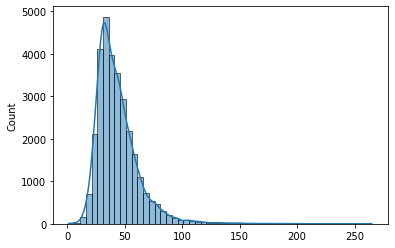

In [7]:
sns.histplot(x=d,binwidth=5,kde=True)

In [8]:
def smiles_to_onehot(smi_list):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles) < max_length:
            smiles += " "
        vector = [vocab.index(str(x)) for x in smiles]
        one_hot = np.zeros((len(vocab), max_length), dtype=int)
        for i, elm in enumerate(vector):
            one_hot[elm][i] = 1
        return one_hot

    vocab = np.load('./vocab.npy')
    smi_total = []

    for i, smi in tqdm_notebook(enumerate(smi_list), desc='Converting to One Hot'):
        smi_onehot = smiles_to_vector(smi, list(vocab), 180)
        smi_total.append(smi_onehot)

    return np.asarray(smi_total)

def convert_to_graph(smiles_list):
    adj = []
    adj_norm = []
    features = []
    maxNumAtoms = 50 ### 합성곱을 위한 원자 수 ###
    for i in tqdm_notebook(smiles_list, desc='Converting to Graph'):
        # Mol
        iMol = Chem.MolFromSmiles(i.strip())
        #Adj
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        # Feature
        if( iAdjTmp.shape[0] <= maxNumAtoms):
            # Feature-preprocessing ####
            iFeature = np.zeros((maxNumAtoms, 60))
            iFeatureTmp = []
            for atom in iMol.GetAtoms():
                iFeatureTmp.append( atom_feature(atom) ) ### atom features only
            iFeature[0:len(iFeatureTmp), 0:60] = iFeatureTmp ### 0 padding for feature-set
            features.append(iFeature)

            # Adj-preprocessing ####
            iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
    features = np.asarray(features)

    return features, adj
    
def atom_feature(atom):
    '''
    GetSymbol - 원자 기호(문자열)를 반환합니다.
    GetDegree - 분자 내 원자의 각도를 반환합니다. 원자의 각도는 직접 결합된 이웃의 수로 정의됩니다.
    GetTotalNumHs - 원자의 총 H(명시적 및 암시적) 수를 반환합니다.
    GetImplicitValence - 원자의 암시적 H 수를 반환합니다.
    GetIsAromatic - 방향성
    '''
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) +
                    [atom.GetIsAromatic()])    # (40, 7, 5, 7, 1) 60

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

In [9]:
list_smi, list_y = read_ZINC_smiles(df, 24000)
# 30341

C:\Users\Tiger\anaconda3\envs\project_5\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Reading Data:   0%|          | 0/24000 [00:00<?, ?it/s]

In [10]:
list_feature, list_adj = convert_to_graph(list_smi)

C:\Users\Tiger\anaconda3\envs\project_5\lib\site-packages\ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Converting to Graph:   0%|          | 0/24000 [00:00<?, ?it/s]

In [11]:
list_feature[0].shape

(50, 60)

In [12]:
list_adj[0].shape

(50, 50)

In [13]:
class GCNDataset(Dataset):
    def __init__(self, list_feature, list_adj, list_y):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_y = list_y

    def __len__(self):
        return len(self.list_feature)

    def __getitem__(self, index):
        return self.list_feature[index], self.list_adj[index], self.list_y[index]


def partition(list_feature, list_adj, list_y, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)

    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    y_train = list_y[:num_train]
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    y_val = list_y[num_train:num_train + num_val]
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_total - num_test:]
    y_test = list_y[num_total - num_test:]
        
    train_set = GCNDataset(feature_train, adj_train, y_train)
    val_set = GCNDataset(feature_val, adj_val, y_val)
    test_set = GCNDataset(feature_test, adj_test, y_test)

    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

In [14]:
dict_partition = partition(list_feature, list_adj, list_y, args)

In [15]:
class SkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        out = in_x + out_x
        return out

In [16]:
class GatedSkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)        
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out
            
    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)

In [17]:
class Attention(nn.Module):
    
    def __init__(self, in_dim, output_dim, num_head=1):
        super(Attention, self).__init__()
        
        self.num_head = num_head
        self.atn_dim = output_dim // num_head
        
        self.linears = nn.ModuleList()
        self.corelations = nn.ParameterList()
        for i in range(self.num_head):
            self.linears.append(nn.Linear(in_dim, self.atn_dim))
            corelation = torch.FloatTensor(self.atn_dim, self.atn_dim)
            nn.init.xavier_uniform_(corelation)
            self.corelations.append(nn.Parameter(corelation))
            
        self.tanh = nn.Tanh()
        
    def forward(self, x, adj):
        heads = list()
        for i in range(self.num_head):
            x_transformed = self.linears[i](x)
            alpha = self.attention_matrix(x_transformed, self.corelations[i], adj)
            x_head = torch.matmul(alpha, x_transformed)
            heads.append(x_head)
        output = torch.cat(heads, dim=2)
        return output
            
    def attention_matrix(self, x_transformed, corelation, adj):
        x = torch.einsum('akj,ij->aki', (x_transformed, corelation))
        alpha = torch.matmul(x, torch.transpose(x_transformed, 1, 2))
        alpha = torch.mul(alpha, adj)
        alpha = self.tanh(alpha)
        return alpha

In [18]:
class GCNLayer(nn.Module):
    
    def __init__(self, in_dim, out_dim, n_atom, act=None, bn=False, atn=False, num_head=1, dropout=0):
        super(GCNLayer, self).__init__()
        
        self.use_bn = bn
        self.use_atn = atn
        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.bn = nn.BatchNorm1d(n_atom)
        self.attention = Attention(out_dim, out_dim, num_head)
        self.activation = act
        self.dropout_rate = dropout
        self.dropout = nn.Dropout2d(self.dropout_rate)
        
    def forward(self, x, adj):
        out = self.linear(x)
        if self.use_atn:
            out = self.attention(out, adj)
        else:
            out = torch.matmul(adj, out) ### 합성곱 연산 - 
        if self.use_bn:
            out = self.bn(out)
        if self.activation != None:
            out = self.activation(out)
        if self.dropout_rate > 0:
            out = self.dropout(out)
        return out, adj

In [19]:
class GCNBlock(nn.Module):
    
    def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, atn=True, num_head=1, sc='gsc', dropout=0):
        super(GCNBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(n_layer):
            self.layers.append(GCNLayer(in_dim if i==0 else hidden_dim,
                                        out_dim if i==n_layer-1 else hidden_dim,
                                        n_atom,
                                        nn.ReLU() if i!=n_layer-1 else None,
                                        bn,
                                        atn,
                                        num_head,
                                        dropout))
        self.relu = nn.ReLU()
        if sc=='gsc':
            self.sc = GatedSkipConnection(in_dim, out_dim)
        elif sc=='sc':
            self.sc = SkipConnection(in_dim, out_dim)
        elif sc=='no':
            self.sc = None
        else:
            assert False, "Wrong sc type."
        
    def forward(self, x, adj):
        residual = x
        for i, layer in enumerate(self.layers):
            out, adj = layer((x if i==0 else out), adj)
        if self.sc != None:
            out = self.sc(residual, out)
        out = self.relu(out)
        return out, adj

In [20]:
class ReadOut(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim= out_dim
        
        self.linear = nn.Linear(self.in_dim, 
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out

In [21]:
class Predictor(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out

In [22]:
class GCNNet(nn.Module):
    
    def __init__(self, args):
        super(GCNNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        for i in range(args.n_block):
            self.blocks.append(GCNBlock(args.n_layer,
                                        args.in_dim if i==0 else args.hidden_dim,
                                        args.hidden_dim,
                                        args.hidden_dim,
                                        args.n_atom,
                                        args.bn,
                                        args.atn,
                                        args.num_head,
                                        args.sc,
                                        args.dropout))
        self.readout = ReadOut(args.hidden_dim, 
                               args.pred_dim1,
                               act=nn.ReLU())
        self.pred1 = Predictor(args.pred_dim1,
                               args.pred_dim2,
                               act=nn.ReLU())
        self.pred2 = Predictor(args.pred_dim2,
                               args.pred_dim3,
                               act=nn.Tanh())
        self.pred3 = Predictor(args.pred_dim3,
                               args.out_dim)
        
    def forward(self, x, adj):
        for i, block in enumerate(self.blocks):
            out, adj = block((x if i==0 else out), adj)
        out = self.readout(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        return out

In [23]:
def train(model, device, optimizer, criterion, data_train, bar, args):
    
    model.train()
    
    epoch_train_loss = 0
    
    for i, batch in enumerate(data_train):
        optimizer.zero_grad()
        
        list_feature = torch.tensor(batch[0]).to(device).float()
        list_adj = torch.tensor(batch[1]).to(device).float()
        list_y = torch.tensor(batch[2]).to(device).float()
        list_y = list_y.view(-1,1)
        
        list_pred_y = model(list_feature, list_adj)
        list_pred_y.require_grad = False
        train_loss = criterion(list_pred_y, list_y)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
       
        bar.update(len(list_feature))

    epoch_train_loss /= len(data_train)
    
    return model, epoch_train_loss

In [24]:
def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()
            list_y = torch.tensor(batch[2]).to(device).float()
            list_y = list_y.view(-1,1)

            model.eval()
            list_pred_y = model(list_feature, list_adj)
            list_pred_y.require_grad = False
            val_loss = criterion(list_pred_y, list_y)
            epoch_val_loss += val_loss.item()
            
            bar.update(len(list_feature))

    epoch_val_loss /= len(data_val)
    
    return model, epoch_val_loss

In [25]:
def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        y_total = list()
        pred_y_total = list()
        for i, batch in enumerate(data_test):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()
            list_y = torch.tensor(batch[2]).to(device).float()
            y_total += list_y.tolist()
            list_y = list_y.view(-1,1)

            list_pred_y = model(list_feature, list_adj)
            pred_y_total += list_pred_y.view(-1).tolist()

        mse = mean_squared_error(y_total, pred_y_total)
        std = np.std(np.array(y_total)-np.array(pred_y_total))
        
    return mse, std, y_total, pred_y_total

In [26]:
def experiment(dict_partition, device, bar, args):
    time_start = time.time()
    
    model = GCNNet(args)
    model.to(device)
        
    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'
        
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()

    data_train = DataLoader(dict_partition['train'], 
                            batch_size=args.batch_size,
                            shuffle=args.shuffle)

    data_val = DataLoader(dict_partition['val'],
                          batch_size=args.batch_size,
                          shuffle=args.shuffle)

    min_val_loss = np.Inf
    n_epochs_stop = 5
    epochs_no_improve = 0
    early_stop = False
    iter = 0
    
    for epoch in range(args.epoch):
        scheduler.step()
        model, train_loss = train(model, device, optimizer, criterion, data_train, bar, args)
        list_train_loss.append(train_loss)
        
        model, val_loss = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)
        
        #print('Epoch {}, Loss(train/val) {:2.3f}/{:2.3f}.'.format(epoch, train_loss, val_loss))
        
        if val_loss < min_val_loss:
            # Save the model
            save_model_path = f'./early_test.pt' # {str(args.l2).split(".")[1]}-
            torch.save(model.state_dict(), save_model_path) 
            epochs_no_improve = 0
            min_val_loss = val_loss

        else:
            epochs_no_improve += 1
        iter += 1
        if epoch > 4 and epochs_no_improve == n_epochs_stop:
            print('Early stopping!' )
            early_stop = True
            break
        else:
            continue

    data_test = DataLoader(dict_partition['test'],
                           batch_size=args.batch_size,
                           shuffle=args.shuffle)

    mse, std, y_total, pred_y_total = test(model, device, data_test, args)
        
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.y_total = y_total
    args.pred_y_total = pred_y_total
    args.mse = mse
    args.std = std
    args.time_required = time_required
    
    return args

In [27]:
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mse = df_result.pivot(var1, var2, 'mse')
    df_std = df_result.pivot(var1, var2, 'std')
    df_mse = df_mse[df_mse.columns].astype(float)
    df_std = df_std[df_std.columns].astype(float)
    
    hm_mse = sns.heatmap(df_mse, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mse.set_title('MSE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)

In [28]:
def plot_performance_bar(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    bar_mse = sns.barplot(x=var1, y='mse', hue=var2, data=df_result, ax=ax[0])
    bar_std = sns.barplot(x=var1, y='std', hue=var2, data=df_result, ax=ax[1])
    
    bar_mse.set_title('mse depends on ' + var1 + ' vs ' + var2)
    bar_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)

In [29]:
def plot_loss(df_result, var1, var2, ylim):
    def plot(x, ylim=1.0, **kwargs):
        plt.plot(x[0], **kwargs)
        plt.ylim(0.0, ylim)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', ylim=ylim, label='Train Loss')
    g.map(plot, 'list_val_loss', ylim=ylim, color='r', label='Validation Loss')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()

In [30]:
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3, s=2)
    def identity(x, y, **kwargs):
        plt.plot(x[0], x[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 'y_total', 'pred_y_total')
    g.map(identity, 'y_total', 'y_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.show()

In [31]:
import warnings
warnings.filterwarnings("ignore")

# [ lr / n_block ]

In [32]:
args.batch_size = 512
args.lr = 0.0005 #
args.l2_coef = 0 #
args.optim = 'Adam'
args.epoch = 50 # 
args.n_block = 2 #
args.n_layer = 1 #
args.n_atom = 50
args.in_dim = 60
args.hidden_dim = 256 #
args.pred_dim1 = 256
args.pred_dim2 = 64 #
args.pred_dim3 = 256 #
args.out_dim = 1
args.bn = False #
args.sc = 'no' #
args.atn = True #
args.num_head = 8 #
args.dropout = 0.1 #
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [33]:
# list_lr = [0.001, 0.0001]
# list_n_block = [1, 2, 3]
list_lr = [0.001, 0.0005, 0.0001] 
list_n_block = [1, 2, 3] 
var1 = 'lr'
var2 = 'n_block'

dict_result = dict()
n_iter = len(list_lr)*len(list_n_block)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for lr in list_lr:
    for n_block in list_n_block:
        args.lr = lr
        args.n_block = n_block
        args.exp_name = var1+':'+str(lr)+'/'+var2+':'+str(n_block)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('./again_json/lr vs n_block.JSON', orient='table')

  0%|          | 0/9720000 [00:00<?, ?it/s]

Early stopping!
lr:0.001/n_block:1 took 51seconds.
Early stopping!
lr:0.001/n_block:2 took 68seconds.
Early stopping!
lr:0.001/n_block:3 took 21seconds.
Early stopping!
lr:0.0005/n_block:1 took 39seconds.
Early stopping!
lr:0.0005/n_block:2 took 68seconds.
Early stopping!
lr:0.0005/n_block:3 took 84seconds.
Early stopping!
lr:0.0001/n_block:1 took 44seconds.
Early stopping!
lr:0.0001/n_block:2 took 68seconds.
Early stopping!
lr:0.0001/n_block:3 took 42seconds.


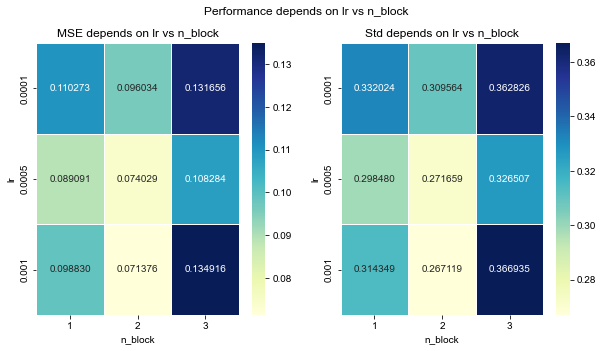

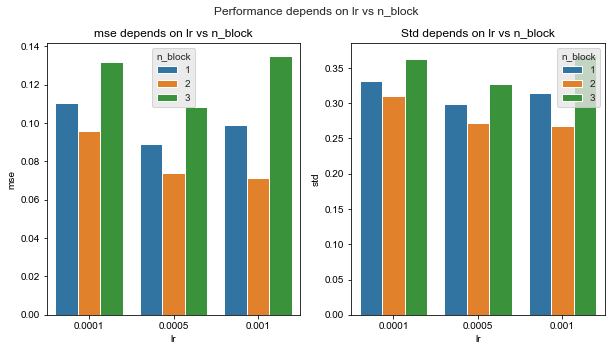

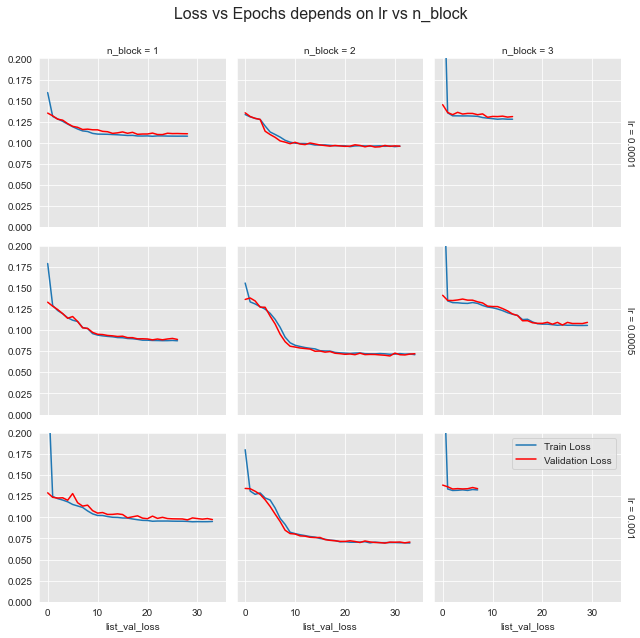

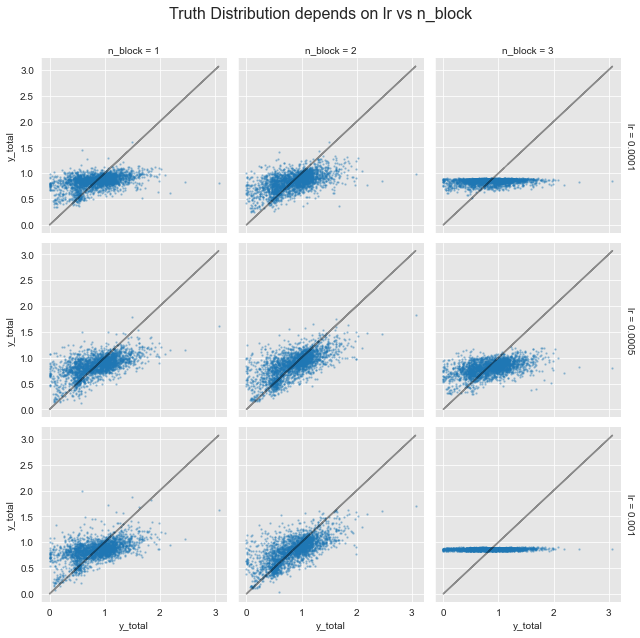

In [34]:
df_result = pd.read_json('./again_json/lr vs n_block.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 0.2)
plot_distribution(df_result, var1, var2)

lr = 0.0005, n_block = 2

# [ n_layer / bn ]

In [36]:
args.batch_size = 512
args.lr = 0.0005 #
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 50
args.n_block = 2 #
args.n_layer = 1
args.n_atom = 50
args.in_dim = 60
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = 1
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 16
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [37]:
list_n_layer = [1, 2, 3]
list_bn = [True, False]
var1 = "n_layer"
var2 = "bn"

dict_result = dict()
n_iter = len(list_n_layer)*len(list_bn)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for n_layer in list_n_layer:
    for bn in list_bn:
        args.n_layer = n_layer
        args.bn = bn
        args.exp_name = var1+':'+str(n_layer)+'/'+var2+':'+str(bn)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('./again_json/n_layer vs bn.JSON', orient='table')

  0%|          | 0/6480000 [00:00<?, ?it/s]

n_layer:1/bn:True took 191seconds.
n_layer:1/bn:False took 181seconds.
n_layer:2/bn:True took 318seconds.
n_layer:2/bn:False took 313seconds.
n_layer:3/bn:True took 439seconds.
n_layer:3/bn:False took 430seconds.


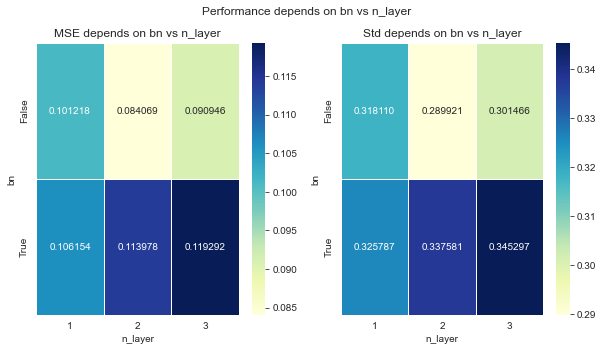

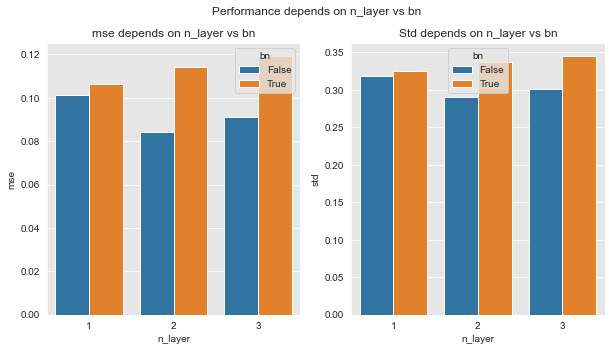

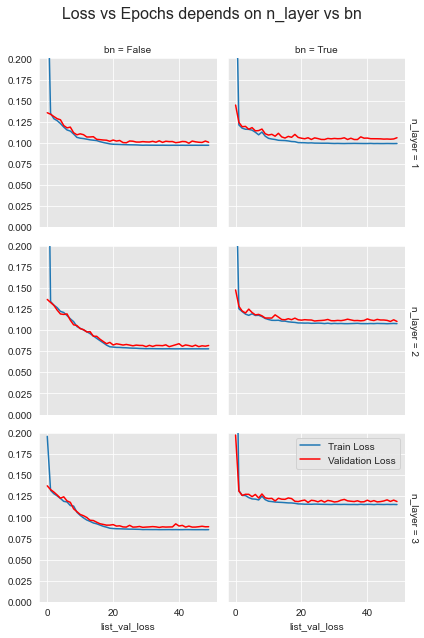

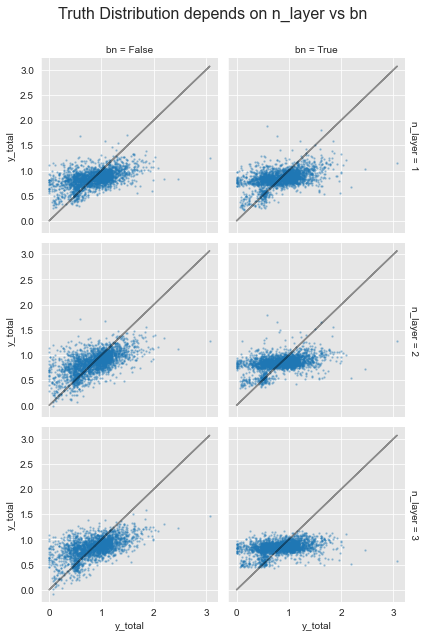

In [38]:
df_result = pd.read_json('./again_json/n_layer vs bn.JSON', orient='table')

plot_performance(df_result, var2, var1)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 0.2)
plot_distribution(df_result, var1, var2)

n_layer = 2, bn = False / 45:03

# [ SC / ATN ]

In [39]:
args.batch_size = 512
args.lr = 0.0005 #
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 50
args.n_block = 2 #
args.n_layer = 2 #
args.n_atom = 50
args.in_dim = 60
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = 1
args.bn = False #
args.sc = 'gsc'
args.atn = True
args.num_head = 16
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [40]:
list_sc = ['no', 'sc', 'gsc']
list_atn = [False, True]
var1 = "sc"
var2 = "atn"

dict_result = dict()
n_iter = len(list_sc)*len(list_atn)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for sc in list_sc:
    for atn in list_atn:
        args.sc = sc
        args.atn = atn
        args.exp_name = var1+':'+str(sc)+'/'+var2+':'+str(atn)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('./again_json/sc vs atn.JSON', orient='table')

  0%|          | 0/6480000 [00:00<?, ?it/s]

sc:no/atn:False took 61seconds.
sc:no/atn:True took 296seconds.
sc:sc/atn:False took 63seconds.
sc:sc/atn:True took 292seconds.
sc:gsc/atn:False took 76seconds.
sc:gsc/atn:True took 314seconds.


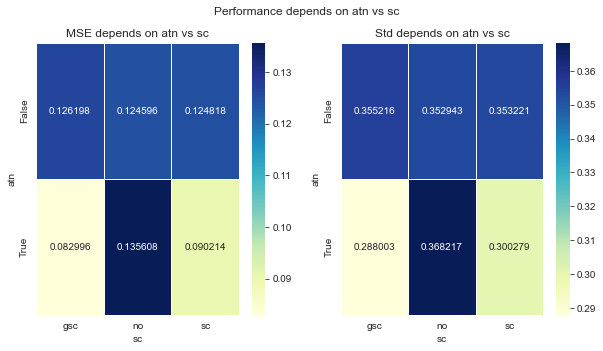

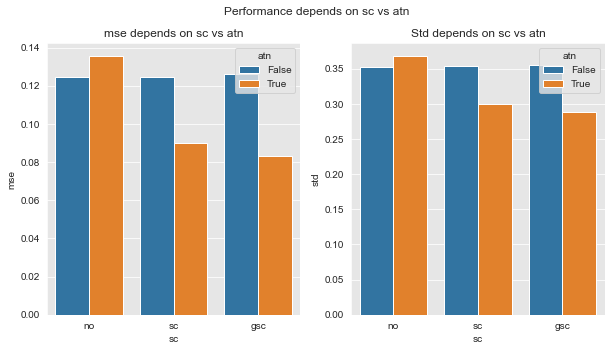

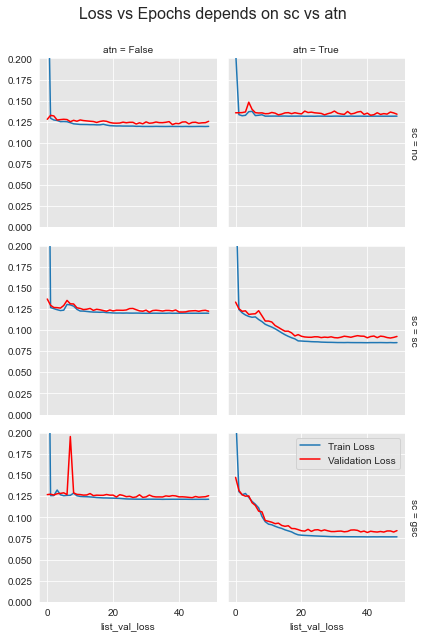

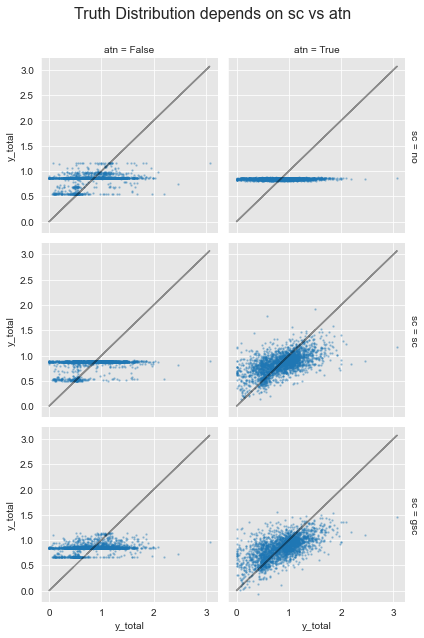

In [41]:
df_result = pd.read_json('./again_json/sc vs atn.JSON', orient='table')

plot_performance(df_result, var2, var1)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 0.2)
plot_distribution(df_result, var1, var2)

SC = gsc, ATN = True / 23:35

# [ hidden_dim / num_head ]

In [35]:
args.batch_size = 512
args.lr = 0.0005 #
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 50
args.n_block = 2 #
args.n_layer = 2 #
args.n_atom = 50
args.in_dim = 60
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = 1
args.bn = False #
args.sc = 'gsc' #
args.atn = True #
args.num_head = 16
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [37]:
list_hidden_dim = [64, 128, 256, 512]
list_num_head = [2, 4, 8, 16]
var1 = "hidden_dim"
var2 = "num_head"

dict_result = dict()
n_iter = len(list_hidden_dim)*len(list_num_head)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for hidden_dim in list_hidden_dim:
    for num_head in list_num_head:
        args.hidden_dim = hidden_dim
        args.num_head = num_head
        args.exp_name = var1+':'+str(hidden_dim)+'/'+var2+':'+str(num_head)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('./again_json/hidden_dim vs num_head.JSON', orient='table')

  0%|          | 0/17280000 [00:00<?, ?it/s]

Early stopping!
hidden_dim:64/num_head:2 took 47seconds.
Early stopping!
hidden_dim:64/num_head:4 took 73seconds.
Early stopping!
hidden_dim:64/num_head:8 took 79seconds.
Early stopping!
hidden_dim:64/num_head:16 took 111seconds.
Early stopping!
hidden_dim:128/num_head:2 took 69seconds.
Early stopping!
hidden_dim:128/num_head:4 took 60seconds.
Early stopping!
hidden_dim:128/num_head:8 took 106seconds.
Early stopping!
hidden_dim:128/num_head:16 took 134seconds.
Early stopping!
hidden_dim:256/num_head:2 took 57seconds.
Early stopping!
hidden_dim:256/num_head:4 took 72seconds.
Early stopping!
hidden_dim:256/num_head:8 took 130seconds.
Early stopping!
hidden_dim:256/num_head:16 took 206seconds.
Early stopping!
hidden_dim:512/num_head:2 took 150seconds.
Early stopping!
hidden_dim:512/num_head:4 took 197seconds.
Early stopping!
hidden_dim:512/num_head:8 took 229seconds.
Early stopping!
hidden_dim:512/num_head:16 took 394seconds.


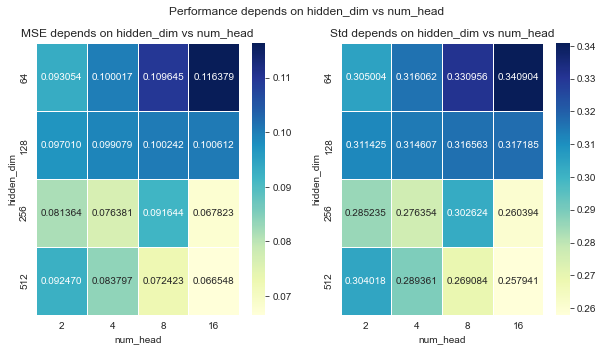

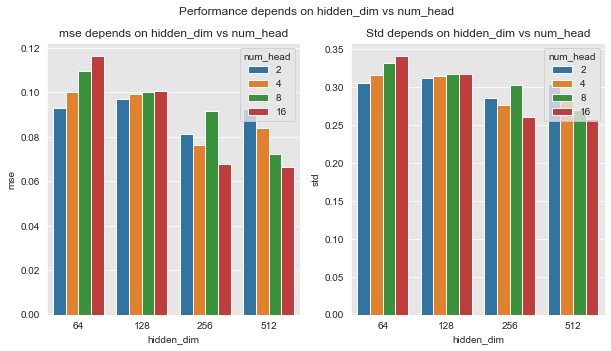

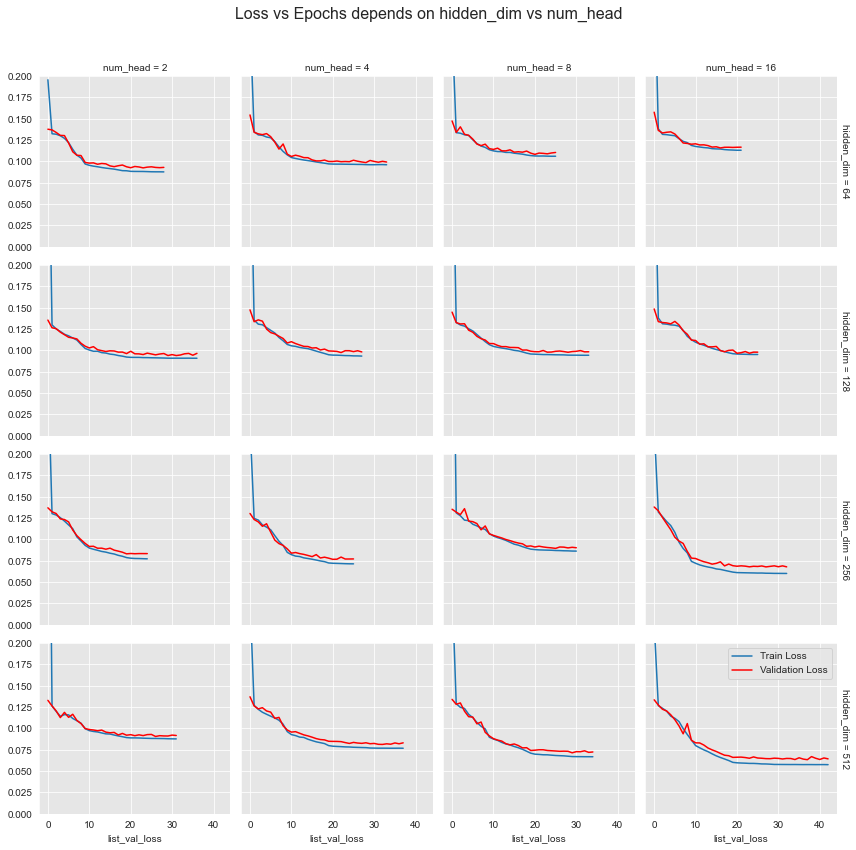

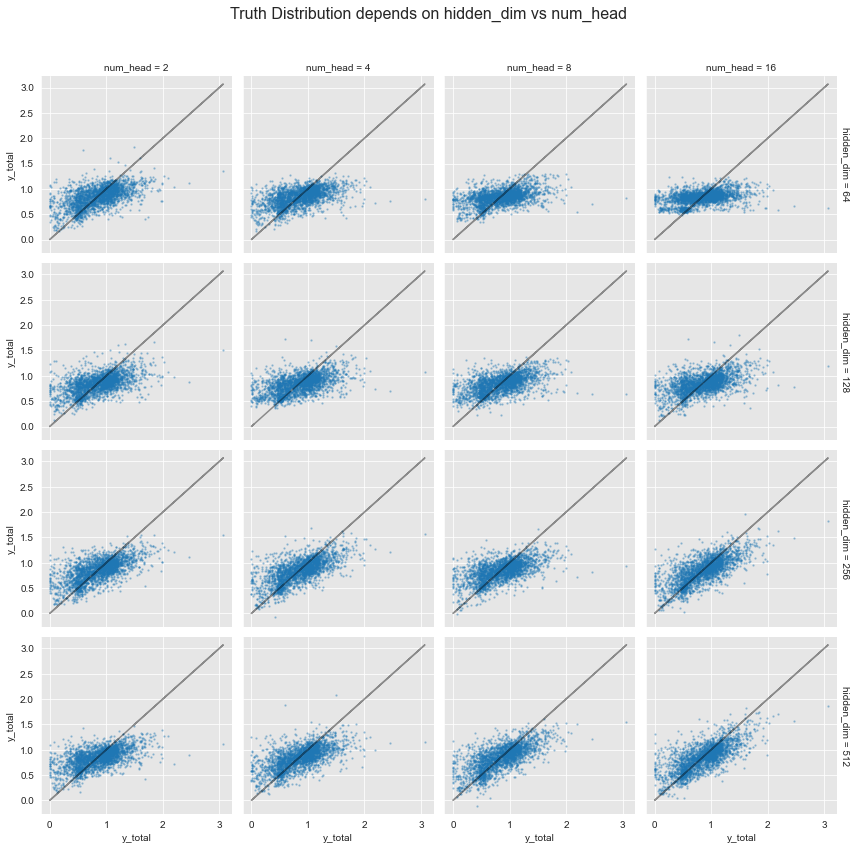

In [38]:
df_result = pd.read_json('./again_json/hidden_dim vs num_head.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 0.2)
plot_distribution(df_result, var1, var2)

num_head = 8 , hidden_dim = 256  / 62:18

# [ pred_dim2 / pred_dim3]

In [50]:
args.batch_size = 512
args.lr = 0.0005 #
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 50
args.n_block = 2 #
args.n_layer = 2 #
args.n_atom = 50
args.in_dim = 60
args.hidden_dim = 256 #
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = 1
args.bn = False #
args.sc = 'gsc' #
args.atn = True #
args.num_head = 8 #
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [51]:
list_pred_dim2 = [64, 128, 256]
list_pred_dim3 = [64, 128, 256]
var1 = "pred_dim2"
var2 = "pred_dim3"

dict_result = dict()
n_iter = len(list_pred_dim2)*len(list_pred_dim3)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for pred_dim2 in list_pred_dim2:
    for pred_dim3 in list_pred_dim3:
        args.pred_dim2 = pred_dim2
        args.pred_dim3 = pred_dim3
        args.exp_name = var1+':'+str(pred_dim2)+'/'+var2+':'+str(pred_dim3)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('./again_json/pred_dim2 vs pred_dim3.JSON', orient='table')

  0%|          | 0/9720000 [00:00<?, ?it/s]

pred_dim2:64/pred_dim3:64 took 196seconds.
pred_dim2:64/pred_dim3:128 took 197seconds.
pred_dim2:64/pred_dim3:256 took 196seconds.
pred_dim2:128/pred_dim3:64 took 197seconds.
pred_dim2:128/pred_dim3:128 took 196seconds.
pred_dim2:128/pred_dim3:256 took 196seconds.
pred_dim2:256/pred_dim3:64 took 197seconds.
pred_dim2:256/pred_dim3:128 took 196seconds.
pred_dim2:256/pred_dim3:256 took 196seconds.


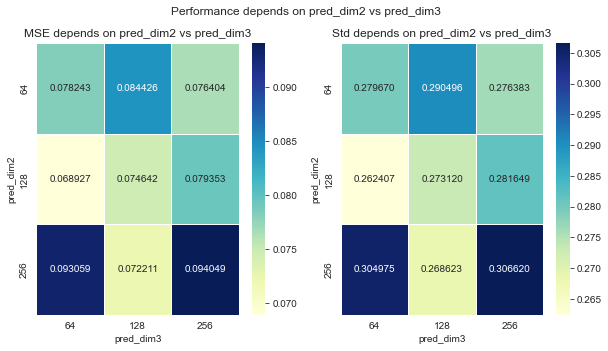

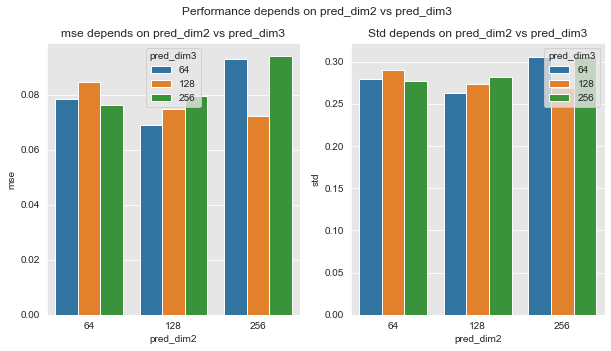

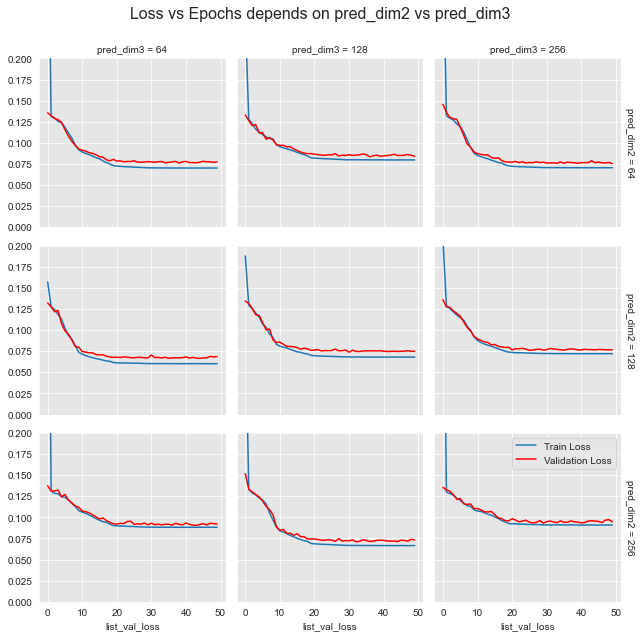

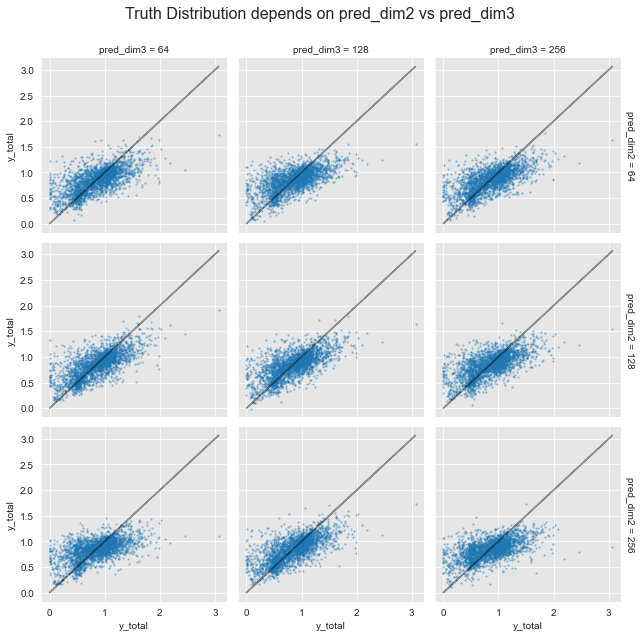

In [52]:
df_result = pd.read_json('./again_json/pred_dim2 vs pred_dim3.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 0.2)
plot_distribution(df_result, var1, var2)

pred_dim2 = 128, pred_dim3 = 64 / 66:00

# [ L2_coef / Dropout ]

In [53]:
args.batch_size = 512
args.lr = 0.0005 #
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 50
args.n_block = 2 #
args.n_layer = 2 #
args.n_atom = 50
args.in_dim = 60
args.hidden_dim = 256 #
args.pred_dim1 = 256
args.pred_dim2 = 128 #
args.pred_dim3 = 64 #
args.out_dim = 1
args.bn = False #
args.sc = 'gsc' #
args.atn = True #
args.num_head = 8 #
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [54]:
list_l2_coef = [0.01, 0.001, 0.0001, 0]
list_dropout = [0, 0.1, 0.2, 0.3]
var1 = "l2_coef"
var2 = "dropout"

dict_result = dict()
n_iter = len(list_l2_coef)*len(list_dropout)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for l2_coef in list_l2_coef:
    for dropout in list_dropout:
        args.l2_coef = l2_coef
        args.dropout = dropout
        args.exp_name = var1+':'+str(l2_coef)+'/'+var2+':'+str(dropout)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('./again_json/l2_coef vs dropout.JSON', orient='table')

  0%|          | 0/17280000 [00:00<?, ?it/s]

l2_coef:0.01/dropout:0 took 206seconds.
l2_coef:0.01/dropout:0.1 took 210seconds.
l2_coef:0.01/dropout:0.2 took 212seconds.
l2_coef:0.01/dropout:0.3 took 212seconds.
l2_coef:0.001/dropout:0 took 209seconds.
l2_coef:0.001/dropout:0.1 took 217seconds.
l2_coef:0.001/dropout:0.2 took 213seconds.
l2_coef:0.001/dropout:0.3 took 212seconds.
l2_coef:0.0001/dropout:0 took 218seconds.
l2_coef:0.0001/dropout:0.1 took 242seconds.
l2_coef:0.0001/dropout:0.2 took 220seconds.
l2_coef:0.0001/dropout:0.3 took 222seconds.
l2_coef:0/dropout:0 took 197seconds.
l2_coef:0/dropout:0.1 took 206seconds.
l2_coef:0/dropout:0.2 took 207seconds.
l2_coef:0/dropout:0.3 took 208seconds.


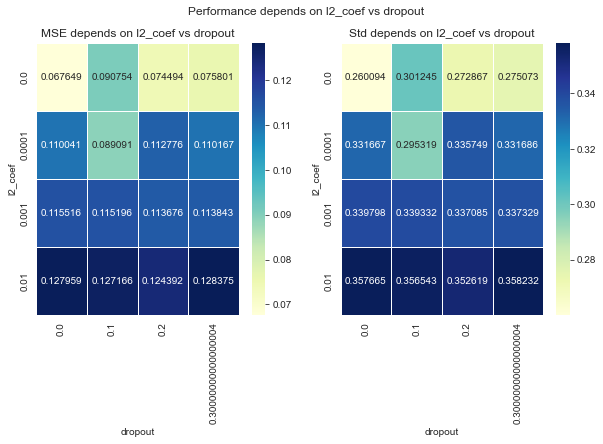

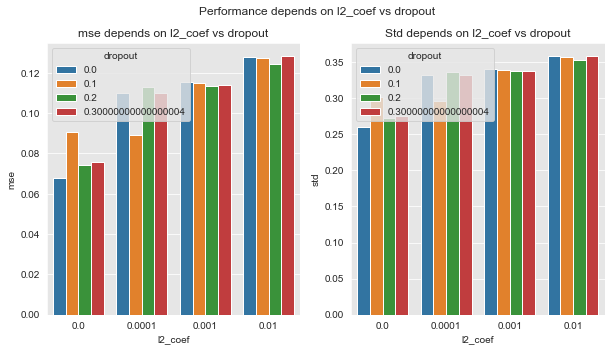

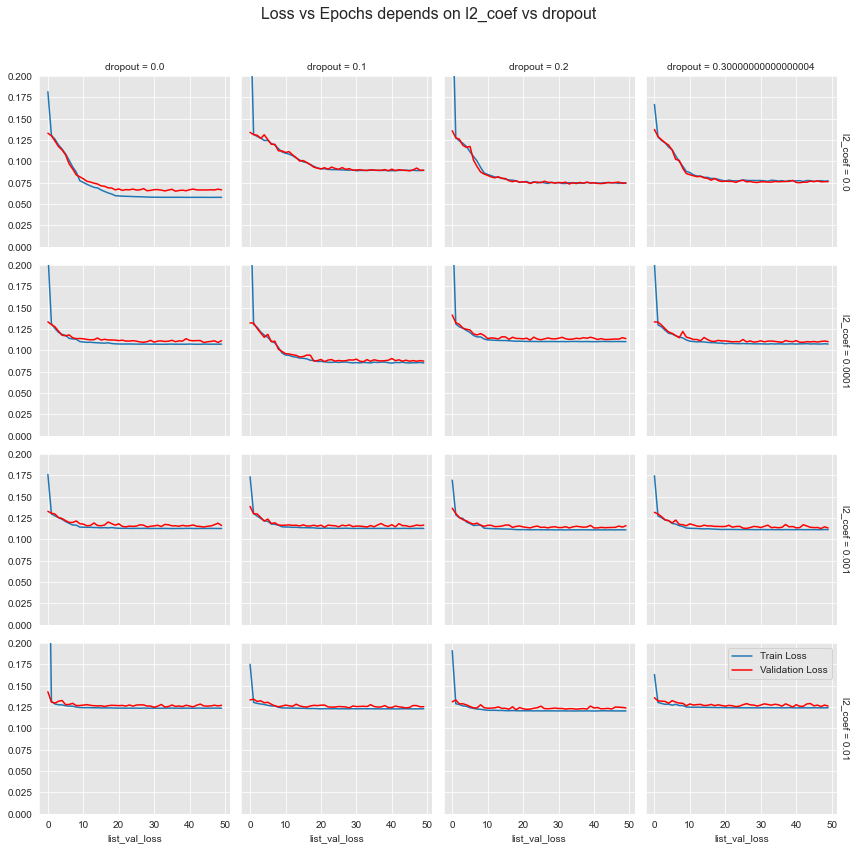

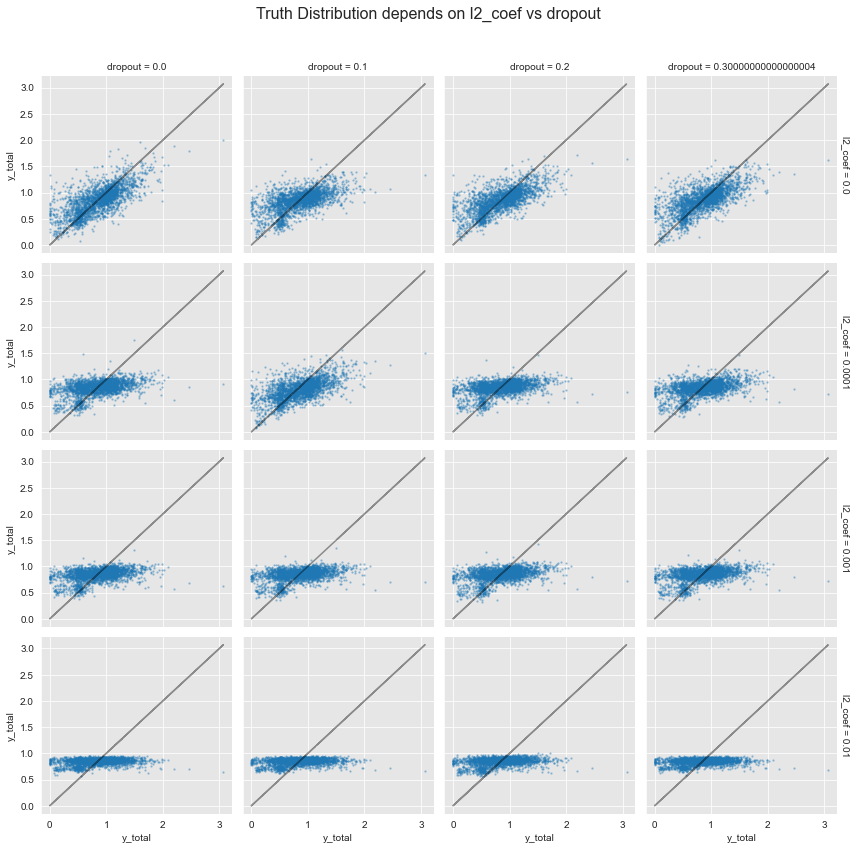

In [55]:
df_result = pd.read_json('./again_json/l2_coef vs dropout.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 0.2)
plot_distribution(df_result, var1, var2)

# [ Best ]

In [56]:
args.batch_size = 512
args.lr = 0.0005 #
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 50
args.n_block = 2 #
args.n_layer = 2 #
args.n_atom = 50
args.in_dim = 60
args.hidden_dim = 256 #
args.pred_dim1 = 256
args.pred_dim2 = 128 #
args.pred_dim3 = 64 #
args.out_dim = 1
args.bn = False #
args.sc = 'gsc' #
args.atn = True #
args.num_head = 8 #
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [57]:
list_smi, list_y = read_ZINC_smiles(df, 30341)
list_feature, list_adj = convert_to_graph(list_smi)
dict_partition = partition(list_feature, list_adj, list_y, args)

Reading Data:   0%|          | 0/30341 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/30341 [00:00<?, ?it/s]

In [58]:
dict_result = dict()
n_iter = args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

args.exp_name = "result ttt"
result = vars(experiment(dict_partition, device, bar, args))
dict_result[args.exp_name] = copy.deepcopy(result)

torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('result ttt.JSON', orient='table')

  0%|          | 0/1339450 [00:00<?, ?it/s]

MSE: 0.1741883089
Std: 0.4172715326


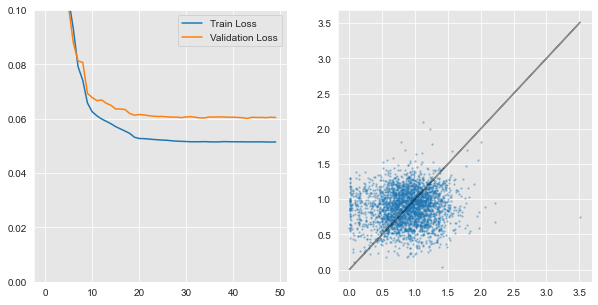

In [59]:
df_result = pd.read_json('result ttt.JSON', orient='table')

print("MSE: " + str(df_result['mse'][0]))
print("Std: " + str(df_result['std'][0]))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax[0].plot(df_result['list_train_loss'][0], label='Train Loss')
ax[0].plot(df_result['list_val_loss'][0], label='Validation Loss')
ax[0].set_ylim([0, 0.1])
ax[0].legend()
ax[1].scatter(df_result['y_total'][0], df_result['pred_y_total'][0], alpha=0.3, s=2)
ax[1].plot(df_result['y_total'][0], df_result['y_total'][0], color='black', alpha=0.4)
# ax[1].set_xlim([0, 2.0])
# ax[1].set_ylim([0, 2.0])

# [ 데이터의 특징 발견 ]

Reading Data:   0%|          | 0/1000 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/45000 [00:00<?, ?it/s]

MSE: 0.1515351205
Std: 0.3814766959


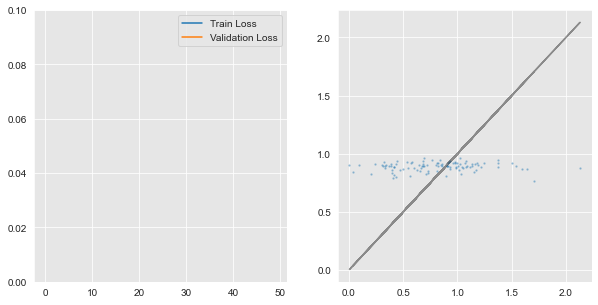

Reading Data:   0%|          | 0/6000 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/270000 [00:00<?, ?it/s]

MSE: 0.1271208629
Std: 0.3557430446


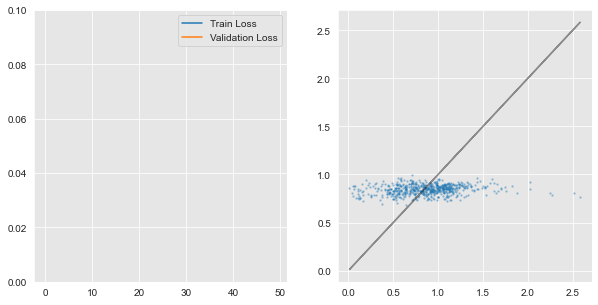

Reading Data:   0%|          | 0/12000 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/540000 [00:00<?, ?it/s]

MSE: 0.10961128590000001
Std: 0.33107376250000004


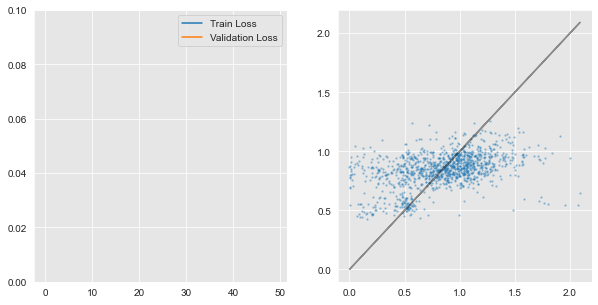

Reading Data:   0%|          | 0/18000 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/18000 [00:00<?, ?it/s]

  0%|          | 0/810000 [00:00<?, ?it/s]

MSE: 0.08836020530000001
Std: 0.29713857850000003


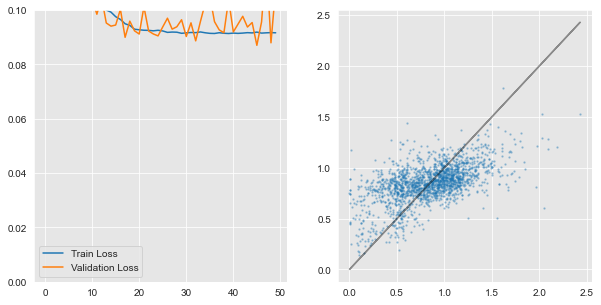

Reading Data:   0%|          | 0/24000 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/24000 [00:00<?, ?it/s]

  0%|          | 0/1080000 [00:00<?, ?it/s]

MSE: 0.0761074838
Std: 0.2758442872


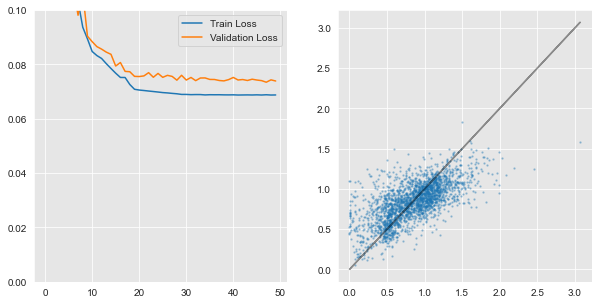

Reading Data:   0%|          | 0/27000 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/27000 [00:00<?, ?it/s]

  0%|          | 0/1215000 [00:00<?, ?it/s]

MSE: 0.0637302049
Std: 0.2524445741


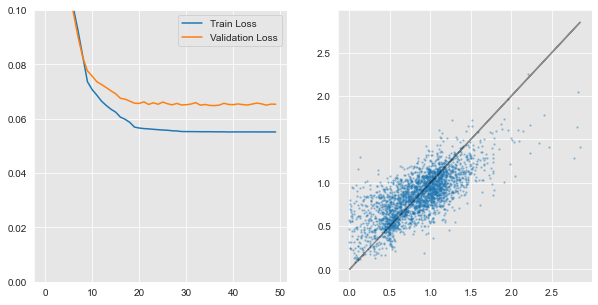

Reading Data:   0%|          | 0/30341 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/30341 [00:00<?, ?it/s]

  0%|          | 0/1339450 [00:00<?, ?it/s]

MSE: 0.1644234604
Std: 0.40522519970000004


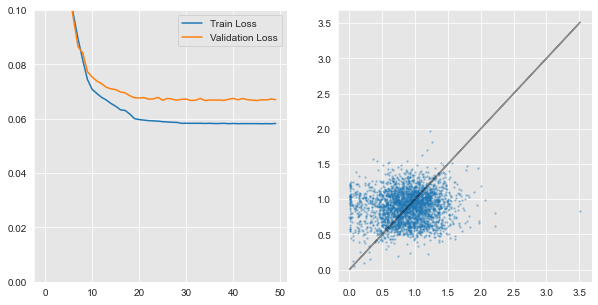

In [60]:
go_tonight = [1000, 6000, 12000, 18000, 24000, 27000, 30341]
gr = []
for i, number in enumerate(go_tonight):
    list_smi, list_y = read_ZINC_smiles(df, number)
    list_feature, list_adj = convert_to_graph(list_smi)
    dict_partition = partition(list_feature, list_adj, list_y, args)

    dict_result = dict()
    n_iter = args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
    bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

    args.exp_name = "result ttt"
    result = vars(experiment(dict_partition, device, bar, args))
    dict_result[args.exp_name] = copy.deepcopy(result)

    torch.cuda.empty_cache()
    bar.close()

    df_result = pd.DataFrame(dict_result).transpose()
    df_result.to_json('result ttt.JSON', orient='table')

    df_result = pd.read_json('result ttt.JSON', orient='table')

    print("MSE: " + str(df_result['mse'][0]))
    print("Std: " + str(df_result['std'][0]))
    gr.append(df_result['mse'][0])

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    ax[0].plot(df_result['list_train_loss'][0], label='Train Loss')
    ax[0].plot(df_result['list_val_loss'][0], label='Validation Loss')
    ax[0].set_ylim([0, 0.1])
    ax[0].legend()
    ax[1].scatter(df_result['y_total'][0], df_result['pred_y_total'][0], alpha=0.3, s=2)
    ax[1].plot(df_result['y_total'][0], df_result['y_total'][0], color='black', alpha=0.4)
    plt.show()


[0.1515351205, 0.1271208629, 0.10961128590000001, 0.08836020530000001, 0.0761074838, 0.0637302049, 0.1644234604]


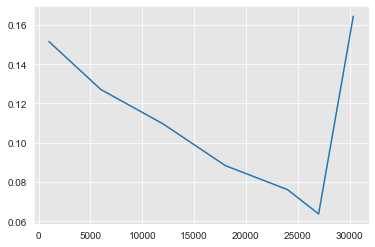

In [61]:
x_l = go_tonight
plt.plot(x_l, gr)
print(gr)

27000번 이후의 데이터 종류가 다를 것이라 추정.

27000번 까지로 학습한 데이터로 sub 제출

In [62]:
list_smi, list_y = read_ZINC_smiles(df, 27000)
list_feature, list_adj = convert_to_graph(list_smi)
dict_partition = partition(list_feature, list_adj, list_y, args)

Reading Data:   0%|          | 0/27000 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/27000 [00:00<?, ?it/s]

In [63]:
dict_result = dict()
n_iter = args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

time_start = time.time()
    
model = GCNNet(args)
model.to(device)

optimizer = optim.Adam(model.parameters(),
                        lr=args.lr,
                        weight_decay=args.l2_coef)

criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                        step_size=args.step_size,
                                        gamma=args.gamma)

list_train_loss = list()
list_val_loss = list()

data_train = DataLoader(dict_partition['train'], 
                        batch_size=args.batch_size,
                        shuffle=args.shuffle)

data_val = DataLoader(dict_partition['val'],
                        batch_size=args.batch_size,
                        shuffle=args.shuffle)

for epoch in range(args.epoch):
    scheduler.step()
    model, train_loss = train(model, device, optimizer, criterion, data_train, bar, args)
    list_train_loss.append(train_loss)
    
    model, val_loss = validate(model, device, criterion, data_val, bar, args)
    list_val_loss.append(val_loss)



  0%|          | 0/1215000 [00:00<?, ?it/s]

In [64]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())



Model's state_dict:
blocks.0.layers.0.linear.weight 	 torch.Size([256, 60])
blocks.0.layers.0.linear.bias 	 torch.Size([256])
blocks.0.layers.0.bn.weight 	 torch.Size([50])
blocks.0.layers.0.bn.bias 	 torch.Size([50])
blocks.0.layers.0.bn.running_mean 	 torch.Size([50])
blocks.0.layers.0.bn.running_var 	 torch.Size([50])
blocks.0.layers.0.bn.num_batches_tracked 	 torch.Size([])
blocks.0.layers.0.attention.linears.0.weight 	 torch.Size([32, 256])
blocks.0.layers.0.attention.linears.0.bias 	 torch.Size([32])
blocks.0.layers.0.attention.linears.1.weight 	 torch.Size([32, 256])
blocks.0.layers.0.attention.linears.1.bias 	 torch.Size([32])
blocks.0.layers.0.attention.linears.2.weight 	 torch.Size([32, 256])
blocks.0.layers.0.attention.linears.2.bias 	 torch.Size([32])
blocks.0.layers.0.attention.linears.3.weight 	 torch.Size([32, 256])
blocks.0.layers.0.attention.linears.3.bias 	 torch.Size([32])
blocks.0.layers.0.attention.linears.4.weight 	 torch.Size([32, 256])
blocks.0.layers.0.attentio

In [ ]:
# 옵티마이저의 state_dict 출력
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [66]:
torch.save(model.state_dict(), './model.pt')

In [67]:
model = GCNNet(args)
model.to(device)

model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [68]:
args.batch_size = 512
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

time_start = time.time()
data_test = DataLoader(dict_partition['test'],
                        batch_size=args.batch_size,
                        shuffle=args.shuffle)

mse, std, y_total, pred_y_total = test(model, device, data_test, args)
    
time_end = time.time()
time_required = time_end - time_start

args.y_total = y_total
args.pred_y_total = pred_y_total
args.mse = mse
args.std = std
args.time_required = time_required

0.07520331178236944


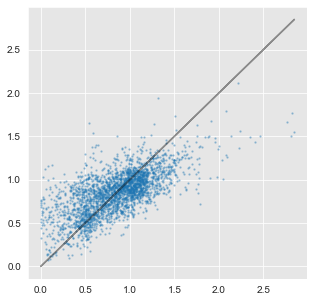

In [69]:
true, pred = y_total, pred_y_total
plt.figure(figsize=(5,5))
plt.scatter(true, pred, alpha=0.3, s=2)
plt.plot(true, true, alpha=0.4, color='black')
print(mse)

# Sub GCN

In [70]:
X_test = pd.read_csv('./data/test.csv')
print(len(X_test))

602


In [71]:
def read_smiles(df, num_mol):
    
    smi_list = []

    for i in tqdm_notebook(range(num_mol), desc='Reading Data'):
        smi = df['SMILES'][i]
        smi_list.append(smi)

    return smi_list

In [72]:
list_smi = read_smiles(df, len(X_test))
list_feature, list_adj = convert_to_graph(list_smi)

Reading Data:   0%|          | 0/602 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/602 [00:00<?, ?it/s]

In [73]:
class Sub_dataset(Dataset):
    def __init__(self, list_feature, list_adj):
        self.list_feature = list_feature
        self.list_adj = list_adj

    def __len__(self):
        return len(self.list_feature)

    def __getitem__(self, index):
        return self.list_feature[index], self.list_adj[index]


def sub_part(list_feature, list_adj):
        
    sub_set = Sub_dataset(list_feature, list_adj)

    return sub_set

In [74]:
sub = sub_part(list_feature, list_adj)

In [75]:
dict_partition['sub'] = sub

In [76]:
def sub(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        pred_y_total = list()
        for i, batch in enumerate(data_test):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()

            list_pred_y = model(list_feature, list_adj)
            pred_y_total += list_pred_y.view(-1).tolist()
        
    return pred_y_total

In [77]:
time_start = time.time()
data_sub = DataLoader(dict_partition['sub'],
                        batch_size=args.batch_size,
                        shuffle=args.shuffle)

pred_y_total = sub(model, device, data_sub, args)
    
time_end = time.time()
time_required = time_end - time_start


args.pred_y_total = pred_y_total
args.time_required = time_required

In [78]:
len(pred_y_total)
print(pred_y_total[:5])

[0.8374464511871338, 0.5462082624435425, 1.025142788887024, 0.7208881378173828, 0.9785357713699341]


In [79]:
sub_gcn = pd.read_csv(f'./data/sample_submission.csv')
sub_gcn['ST1_GAP(eV)'] = pred_y_total
sub_gcn.to_csv('sub_GCN_27000.csv', index=False)

In [80]:
sub_gcn

,uid,ST1_GAP(eV)
0,test_0,0.837446
1,test_1,0.546208
2,test_2,1.025143
3,test_3,0.720888
4,test_4,0.978536
...,...,...
597,test_597,0.286203
598,test_598,1.592476
599,test_599,1.149340
600,test_600,1.034440


public점수 : 0.4401611894 private점수 : 0.398452036